In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from fonksiyonlar import parametre_hesaplama

In [2]:
# Veri setinin yüklenmesi
data = pd.read_csv('winequality-red.csv')
X = data.drop('quality', axis=1)             #Özellikler
y = data['quality']                          #Etiket
y = y.apply(lambda x: 0 if x <= 5 else 1)    #Düşük/Yüksek kalite sınıfları

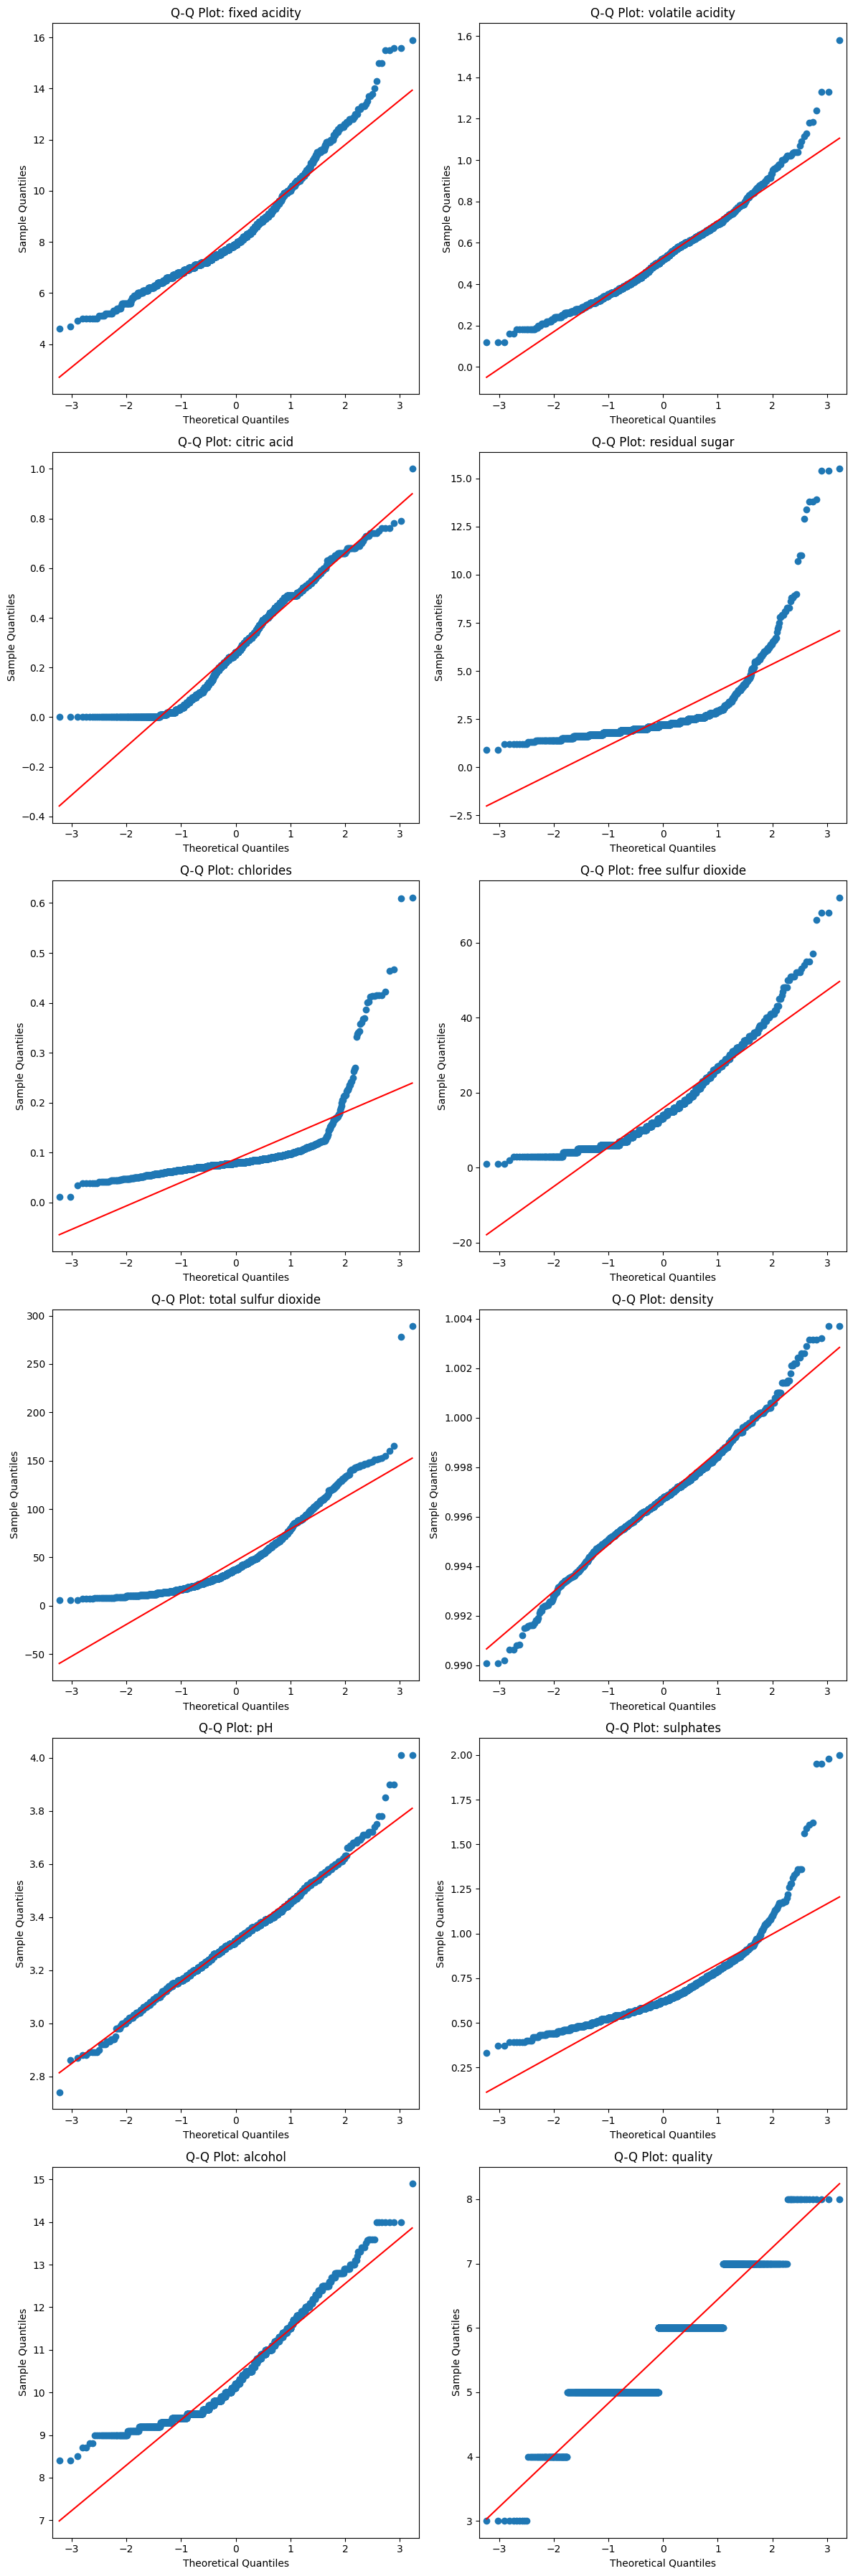

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Özelliklerin isimlerini al
features = data.columns

# Alt grafikler için ayarlar
n_features = len(features)  # Özellik sayısı
rows = (n_features + 1) // 2  # Satır sayısı (2 sütun olacak)
fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows))  # Dinamik boyutlandırma
axes = axes.flatten()  # Aksları düzleştir (indeksle kolay erişim için)

# Her özellik için Q-Q plot
for i, feature in enumerate(features):
    # Özelliği seç
    values = data[feature]

    # Q-Q plot
    sm.qqplot(values, line='s', ax=axes[i])
    axes[i].set_title(f"Q-Q Plot: {feature}")

# Boş grafik alanlarını kaldır
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [3]:
# Korelasyon Tabanlı Özellik Seçimi Yöntemi

# Korelasyon matrisini hesapla
correlation_matrix = X.corr()

# Korelasyonu 0.68'den büyük olan özellik çiftlerini tespit et
threshold = 0.68
to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

# Yüksek korelasyona sahip özellikleri çıkar
X_filtered = X.drop(columns=to_drop)

# print(f"Çıkarılan Özellikler: {to_drop}")
# print(f"Yeni Özellikler: {X_filtered.columns}")
print(f"Çıkarılan Özellikler: {', '.join(to_drop)}")
print(f"Yeni Özellikler: {', '.join(X_filtered.columns)}")

Çıkarılan Özellikler: pH
Yeni Özellikler: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, sulphates, alcohol


In [4]:
# Veri Setini Eğitim ve Test Olarak Bölme 0.2

#X_train, X_test, y_train, y_test = train_test_split(X_filtered.values, y.values, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

# Veriyi Ölçekleme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)     # Eğitim verisi için StandardScaler, her bir özelliğin 
                                            # ortalamasını ve standart sapmasını öğrenir

X_test = scaler.transform(X_test)           # Benzer bir işlem test verisine de uygulanır
                                            # Test verisi sadece eğitim verisinden öğrenilen ortalama ve standart 
                                            # sapma değerleri kullanılarak ölçeklendirilir

# Veri setindeki sınıf dağılımını kontrol etme
class_distribution = Counter(y_train)
for class_label, count in class_distribution.items():
    print(f"Sınıf {class_label}: {count} örnek")

Sınıf 1: 676 örnek
Sınıf 0: 603 örnek


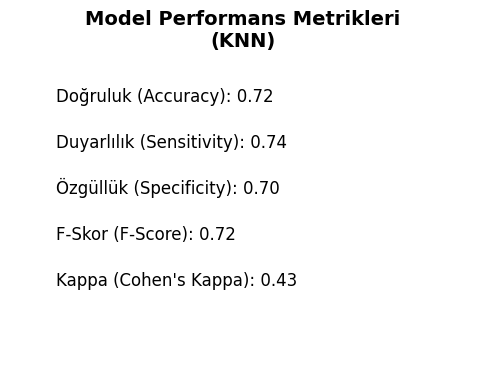

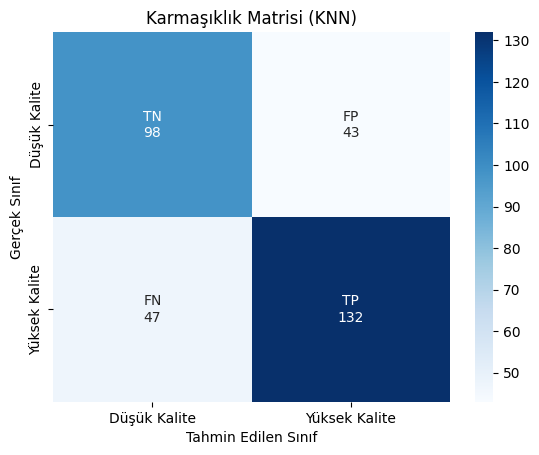

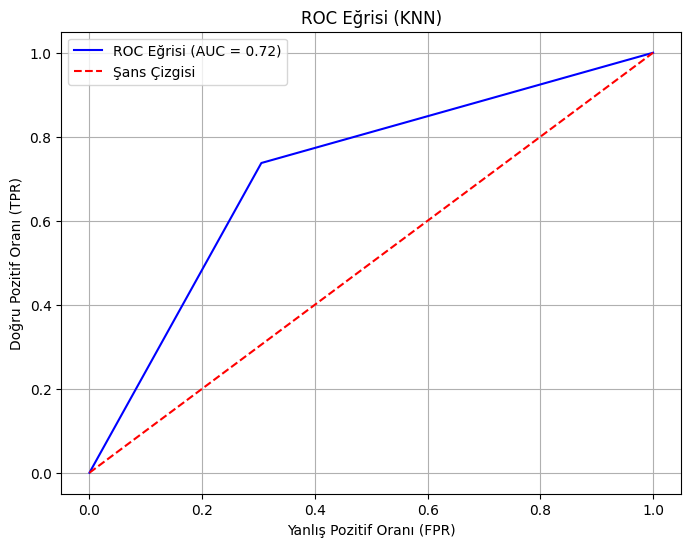

In [30]:
from fonksiyonlar import knn_predict

# KNN Algoritmasını Çalıştırma
k = 40  # En yakın komşu sayısı
y_pred = knn_predict(X_train, y_train, X_test, k)
# KNN Algoritması ile tahmin yapma
parametre_hesaplama(y_test, y_pred, "KNN")

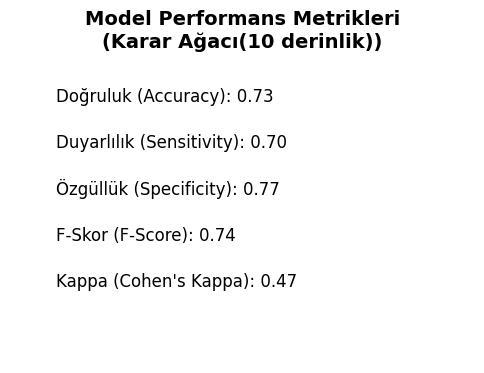

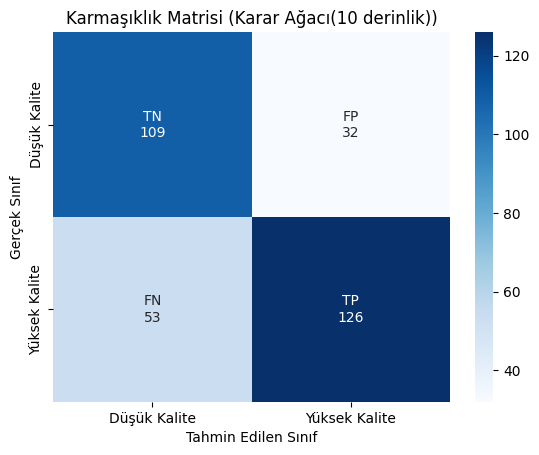

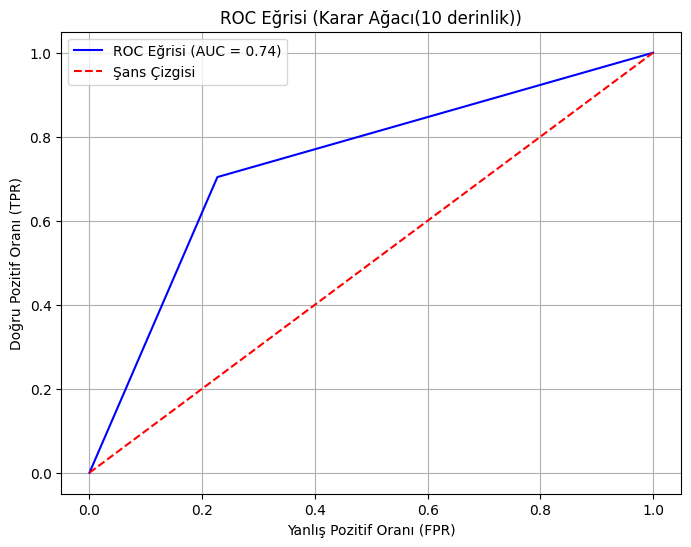

In [31]:
from fonksiyonlar import decision_tree

derinlik = 10 #10

# Karar Ağacı Modelini Eğit
y_pred_dt = decision_tree(X_train, y_train, X_test, max_depth = derinlik)
# Sonuçları değerlendirme
parametre_hesaplama(y_test, y_pred_dt, "Karar Ağacı("+str(derinlik)+" derinlik)")

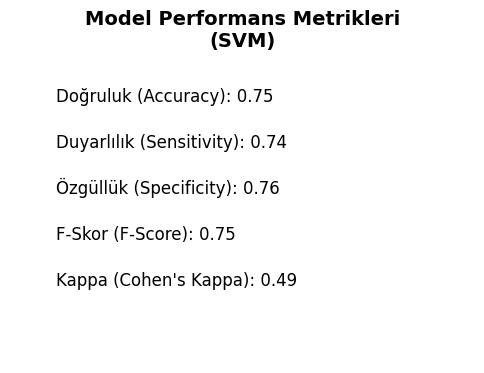

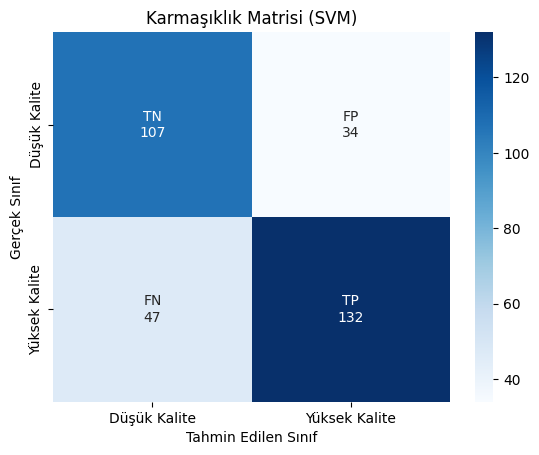

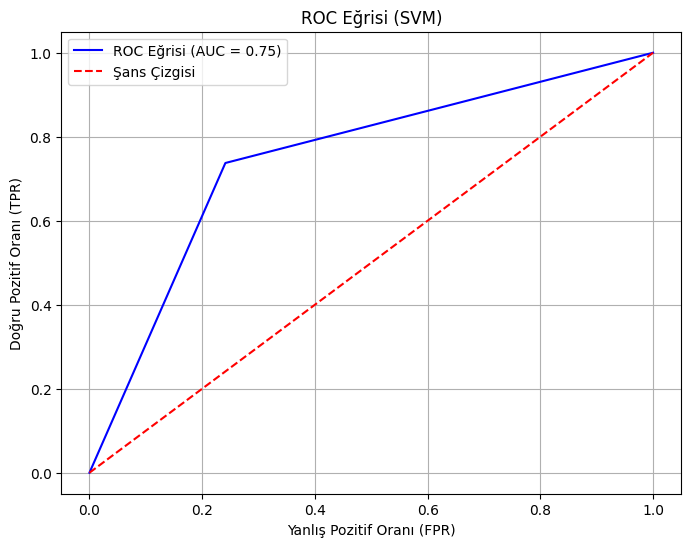

In [32]:
from fonksiyonlar import train_svm, svm_predict

# SVM modelini eğitimi
# lr(öğrenme oranı), modelin ağırlıklarını güncellemek için kullanılan adım boyutunu belirtir
#               Küçük öğrenme oranı, daha yavaş ama daha hassas eğitim süreci sağlar 
# epochs, eğitim verisinin tamamının model tarafından kaç kere işleneceğini belirler
# C, modelin karmaşıklığını dengeler
#               büyük C değeri modelin daha karmaşık olmasına yol açar (daha fazla hata toleransı)
w, b = train_svm(X_train, y_train, lr=0.01, epochs=1000, C=1.0)

# Test verisi üzerinde tahmin yap
y_pred_svm = svm_predict(X_test, w, b)
parametre_hesaplama(y_test, y_pred_svm, "SVM")

c:\Users\SüleymanSefaGürer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


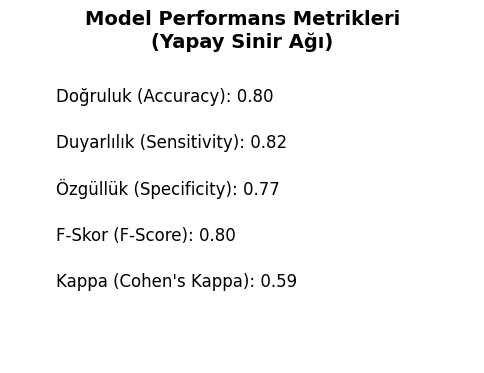

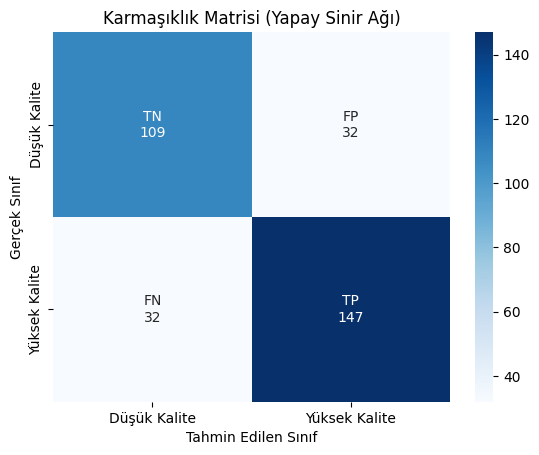

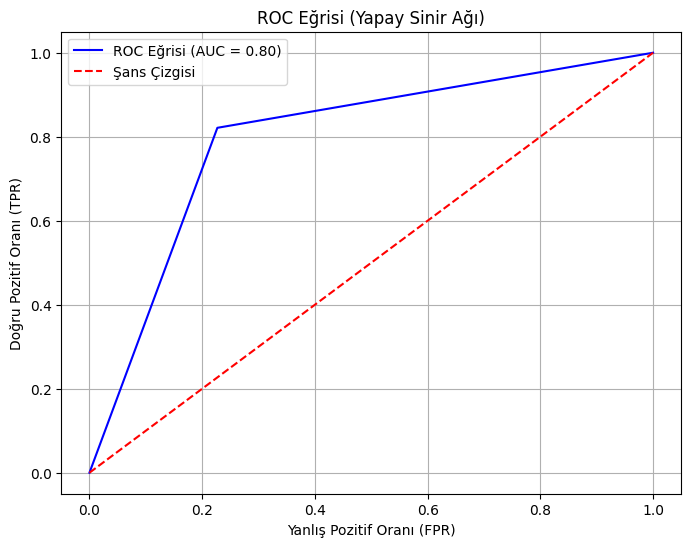

In [33]:
from sklearn.neural_network import MLPClassifier

# Yapay Sinir Ağı Modelini Eğit
# hidden_layer_sizes, gizli katmanların boyutunu belirtir
# max_iter, epoch sayısı
ann_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
ann_model.fit(X_train, y_train)
y_pred_ann = ann_model.predict(X_test)
parametre_hesaplama(y_test, y_pred_ann, "Yapay Sinir Ağı")

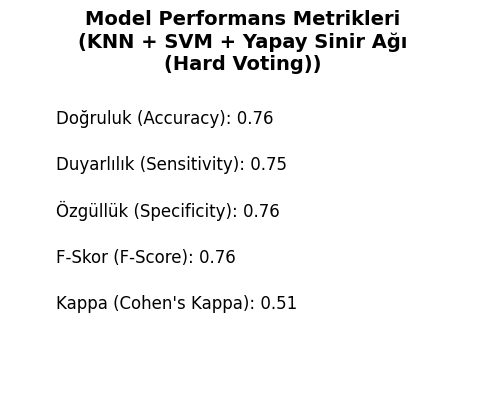

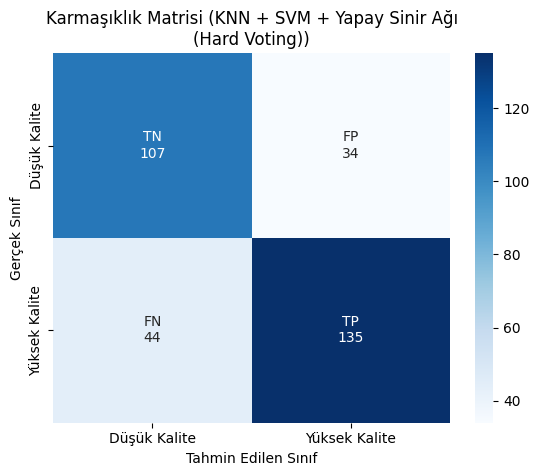

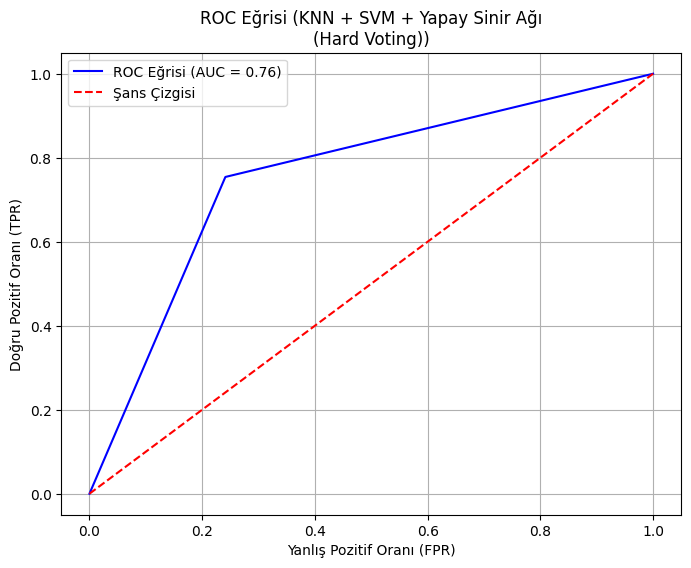

In [34]:
# Topluluk Sınıflandırma (Hard Voting)
combined_predictions_ann = []
for i in range(len(y_test)):
    knn_pred = y_pred[i]
    rf_pred = y_pred_dt[i]
    svm_pred = y_pred_svm[i]
    ann_pred = y_pred_ann[i]
    
    # Çoğunluk oyunu alma
    final_pred = Counter([knn_pred, svm_pred, ann_pred]).most_common(1)[0][0]
    combined_predictions_ann.append(final_pred)

parametre_hesaplama(y_test, combined_predictions_ann, "KNN + SVM + Yapay Sinir Ağı\n(Hard Voting)")